/tmp/ipykernel_32/1826561155.py:12: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  t = torch.tensor((1000/num_inference_steps)*(num_inference_steps-i-1)+1, device=pipe.device, dtype=torch.long)


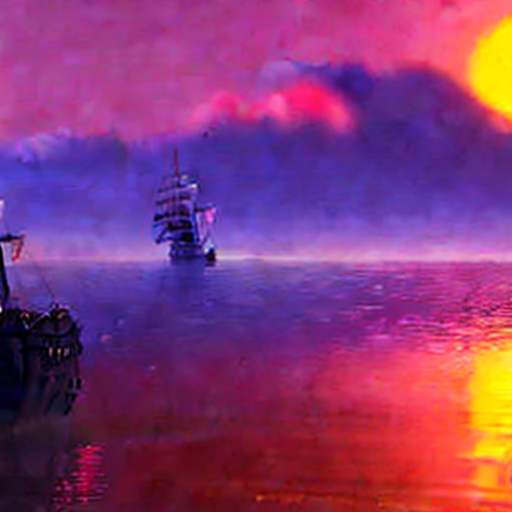

In [5]:
latents = init_latents.detach().clone()

# Denoise loop without scheduler
@torch.no_grad()
def custom_denoise(
	pipe, latents, prompt_embeds, num_inference_steps, guidance_scale, ratio
):
	for i in range(num_inference_steps):
		latent_model_input = torch.cat([latents] * 2)
		
		# Predict the noise residual for the current timestep
		t = torch.tensor((1000/num_inference_steps)*(num_inference_steps-i-1)+1, device=pipe.device, dtype=torch.long)
		noise_residual = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)
		uncond_residual, text_cond_residual = noise_residual.chunk(2)
		guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

		# Update the latents with the predicted noise residual
		latents = latents - (ratio * guided_noise_residual / num_inference_steps)

		#display(pipe.vae_decode(latents))
	return latents

ratio = 1.475
latents = custom_denoise(pipe, latents, prompt_embeds, num_inference_steps, guidance_scale, ratio)
image = pipe.vae_decode(latents)
image